In [93]:
import pandas as pd
import numpy as np
import os

# Anterior and Posterior Teeth as defined by American Dental Association
# https://radiopaedia.org/articles/american-dental-association-universal-numbering-system?lang=us

ANTERIOR = list(range(6, 12)) + list(range(22, 28))
POSTERIOR = list(range(1, 6)) + list(range(12, 22)) + list(range(28, 33))

# Some codings for easier usage later
CODINGS = {
    'ABSENT': 0,
    'PRESENT': 1,

}


def get_data(url='https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_OHXDEN.XPT', path='./dataset/P_OHXDEN.XPT'):
    """
    Load data from path if exists, else pull from url
    @param url: URL of the data
    @type url: str
    @param path: Path of dataset on file system if exists
    @type path: str
    @return: Entire pd.DataFrame
    """
    return pd.read_sas(path if os.path.exists(path) else url)


# OHXxxTC Column Description :
# Code  Description	                            Count	Cumulative  Convert Explanation
# 1	    Primary tooth (deciduous) present	    0	    0           1       Present
# 2	    Permanent tooth present	                7534	7534        1       Present
# 3	    Dental implant	                        4	    7538        0       Absent
# 4	    Tooth not present	                    5609	13147       0       Absent
# 5	    Permanent dental root fragment present	131	    13278       0       Absent
# 9	    Could not assess	                    0	    13278       0       Treat as Absent
# .	    Missing	                                494	    13772       0       Treat as Absent


TOOTH_COUNT_CODINGS = {
    1: 1,  # Primary tooth
    2: 1,  # Perm tooth
    3: 0,  # Implant
    4: 0,
    5: 0,
    9: 0,
    'nan': np.nan
}


def get_tc_col_name(t):
    return 'OHX{tooth:02d}TC'.format(tooth=t)


def get_tooth_count(df, tooth_list, codings=None):
    """
    Gets tooth count from merging TOOTH_COUNT cols for all teeth in tooth_list
    @param codings:
    @param df: DataFrame
    @type df: pd.DataFrame
    @param tooth_list: ANTERIOR or POSTERIOR
    @return: pd.Series of Tooth Count
    """
    if codings is None:
        codings = TOOTH_COUNT_CODINGS
    cols = list(map(get_tc_col_name, tooth_list))
    data = df[cols]
    return data.applymap(lambda x: codings['nan'] if np.isnan(x) else codings[x]).sum(axis=1)


#
#
# Code 	Description	                                                            Count	Cumulative  Convert
# A	    Primary tooth with a restored surface condition	                        0	    0           1
# D	    Sound primary tooth	                                                    0	    0           0
# E	    Missing due to dental disease	                                        1197	1197        3
# F	    Permanent tooth with a restored surface condition	                    2908	4105        1
# J	    Permanent root tip is present but no restorative replacement is present	131	    4236        3
# K	    Primary tooth with a dental carious surface condition	                0	    4236        2
# M	    Missing due to other causes	                                            47	    4283        3
# P	    Missing due to dental disease but replaced by a removable restoration	1019	5302        3
# Q	    Missing due to other causes but replaced by a removable restoration	    37	    5339        3
# R	    Missing due to dental disease but replaced by a fixed restoration	    13	    5352        3
# S	    Sound permanent tooth	                                                4394    9746        0
# T	    Permanent root tip is present but a restorative replacement is present	0	    9746        3
# U	    Unerupted	                                                            3297	13043       nan
# X	    Missing due to other causes but replaced by a fixed restoration	        0	    13043       nan
# Y	    Tooth present, condition cannot be assessed	                            11	    13054       nan
# Z	    Permanent tooth with a dental carious surface condition	                220	    13274       2
# nan	Missing	                                                                498	    13772       nan

CARIES_CODINGS = {
    'A': 1,
    'D': 0,
    'E': 3,
    'F': 1,
    'J': 3,
    'K': 2,
    'M': 3,
    'P': 3,
    'Q': 3,
    'R': 3,
    'S': 0,
    'T': 3,
    'U': np.nan,
    'X': np.nan,
    'Y': np.nan,
    'Z': 2,
    'nan': np.nan,
    '': np.nan
}


def get_tooth_caries_col_name(t):
    return 'OHX{tooth:02d}CTC'.format(tooth=t)


def del_not_present_cols(l, np):
    l1 = l.copy()
    for x in np:
        if x in l1:
            del l1[l1.index(x)]
    return l1


def get_caries_count(df, tooth_list, codings=None):
    """
    Gets tooth count from merging TOOTH_COUNT cols for all teeth in tooth_list
    @param codings:
    @param df: DataFrame
    @type df: pd.DataFrame
    @param tooth_list: ANTERIOR or POSTERIOR
    @return: pd.Series of Tooth Count
    """
    if codings is None:
        codings = CARIES_CODINGS
    # No Caries Col for 1,32
    tl = del_not_present_cols(tooth_list, [1, 16, 17, 32])

    cols = list(map(get_tooth_caries_col_name, tl))
    data = df[cols]
    return data.applymap(lambda x: codings[x.decode()]).sum(axis=1)


#  Dental Sealants Data Description
#
# Code  Description	                                    Count	Cumulative	Convert
# 0	    Sealant not present	                            4194	4194	    0
# 1	    Occlusal sealant on permanent tooth	            102 	4296	    1
# 2	    Facial sealant on permanent tooth	            0	    4296	    1
# 3	    Lingual sealant on permanent tooth	            0	    4296	    1
# 4	    Occlusal sealant on primary tooth	            51	    4347	    1
# 9	    Cannot be assessed	                            41	    4388	    nan
# 12	Occlusal-facial sealant on permanent tooth	    0	    4388	    1
# 13	Occlusal-lingual sealant on permanent tooth	    0	    4388	    1
# nan	Missing	                                        9384	13772       nan

SEALANT_CODINGS = {
    0: 0,
    1: 1,
    2: 1,
    3: 1,
    4: 1,
    9: np.nan,
    12: 1,
    13: 1,
    'nan': np.nan,
    '': np.nan
}


def get_sealant_col_name(t):
    return 'OHX{tooth:02d}SE'.format(tooth=t)


def get_sealant_count(df, tooth_list, codings=None):
    """
    Gets tooth count from merging TOOTH_COUNT cols for all teeth in tooth_list
    @param codings:
    @param df: DataFrame
    @type df: pd.DataFrame
    @param tooth_list: ANTERIOR or POSTERIOR
    @return: pd.Series of Tooth Count
    """
    if codings is None:
        codings = SEALANT_CODINGS
    # No Sealant Col for 1,32
    tl = del_not_present_cols(tooth_list, [1, 6, 8, 9, 11, 16, 17, 22, 23, 24, 25, 26, 27, 32])
    cols = list(map(get_sealant_col_name, tl))
    data = df[cols]
    return data.applymap(lambda x: codings[''] if not x.decode() else codings[int(x.decode())]).sum(axis=1)


#   Root Caries, other lesions X [restored , not] Data Description
# Code Description	            Count   Convert
# 1	    Yes	                    1085    1
# 2	    No	                    6916	0
# 9	    Cannot be accessed	    7		nan
# .	    Missing	                5764	nan

ROOT_CODINGS = {
    1:1,
    2:0,
    9: np.nan,
    'nan': np.nan
}

def get_root_caries(df, codings=None):
    if codings is None:
        codings = ROOT_CODINGS
    data = df[['OHXRCAR', 'OHXRRES']]
    return data.applymap(lambda x: codings['nan'] if np.isnan(x) else codings[x]).sum(axis=1)

def get_other_non_carious_restoration(df, codings=None):
    if codings is None:
        codings = ROOT_CODINGS
    data = df[['OHXRCARO', 'OHXRRESO']]
    return data.applymap(lambda x: codings['nan'] if np.isnan(x) else codings[x]).sum(axis=1)


def preprocess_dental_data():
    df = get_data()
    data = pd.DataFrame(df['SEQN'])
    data['ANTERIOR_TOOTH_COUNT'] = get_tooth_count(df, ANTERIOR)
    data['POSTERIOR_TOOTH_COUNT'] = get_tooth_count(df, POSTERIOR)
    data['ANTERIOR_CARIES_COUNT'] = get_caries_count(df, ANTERIOR)
    data['POSTERIOR_CARIES_COUNT'] = get_caries_count(df, POSTERIOR)
    data['ANTERIOR_DENTAL_SEALANT_COUNT'] = get_sealant_count(df, ANTERIOR)
    data['POSTERIOR_DENTAL_SEALANT_COUNT'] = get_sealant_count(df, POSTERIOR)
    data['ROOT_CARIES'] = get_root_caries(df)
    data['OTHER_NON_CARIOUS_ROOT_LESION'] = get_other_non_carious_restoration(df)
    return data


if __name__ == "__main__":
    # print(get_tooth_count(get_data(), ANTERIOR))
    # print(get_caries_count(get_data(), ANTERIOR))
    # print(get_sealant_count(get_data(), ANTERIOR))
    print(get_root_caries(get_data()))
    print(get_other_non_carious_restoration(get_data()))

/usr/local/lib/python3.7/dist-packages/pandas/io/sas/sas_xport.py:475: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[x] = v


0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
13767    1.0
13768    0.0
13769    0.0
13770    0.0
13771    0.0
Length: 13772, dtype: float64
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
13767    0.0
13768    0.0
13769    0.0
13770    1.0
13771    0.0
Length: 13772, dtype: float64


In [94]:
import pandas as pd
import numpy as np
import os

def preprocess(
        dietary_url='https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_DSQTOT.XPT',
        nutrition_url='https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_DR1TOT.XPT',
        dental_url='https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_OHXDEN.XPT'):
    '''
    @description: 
        Pre-process the Dietary Supplement, Nutrient Intakes, and Dental Health data
    @param: 
        URLs of the three data
    @return: 
        Pre-processed Pandas DataFrame
    '''
    # please be patient for data download
    dietary_path = './dataset/P_DR1TOT.XPT'
    nutrition_path = './dataset/P_DSQTOT.XPT'
    dental_path = './dataset/P_OHXDEN.XPT'

    df_dietary = pd.read_sas(
        dietary_path if os.path.exists(dietary_path) else dietary_url)
    df_nutrition = pd.read_sas(nutrition_path if os.path.exists(
        nutrition_path) else nutrition_url)
    df_dental = preprocess_dental_data()

    df_data = pd.merge(df_dietary, df_nutrition, on='SEQN')
    df_data = pd.merge(df_data, df_dental, on='SEQN')

    # fill the missing precise quantatative or special dietary data with 0
    attrs_set_0 = ['DR1SKY']
    for attr in df_data.columns:
        if attr.startswith('DSQ') or attr.startswith('DRQS') or attr.startswith('DRD'):
            attrs_set_0.append(attr)
    df_data[attrs_set_0] = df_data[attrs_set_0].fillna(0)

    # drop Coronal Caries and Sealants attributes from dental data
    # attrs_keep = []
    # for attr in df_data.columns:
    #     if not (attr.startswith('OHX') and (attr.endswith('CTC') or attr.endswith('CSC')
    #             or attr.endswith('RTC') or attr.endswith('RSC') or attr.endswith('SE'))):
    #         attrs_keep.append(attr)
    # df_data = df_data[attrs_keep]

    # fill missing "dental implant or not?" with "no"
    # df_data.loc[:, 'OHXIMP'].fillna(2, inplace=True)
    # fill missing "how often add salt?" with "don't know"
    df_data.loc[:, 'DBD100'].fillna(9, inplace=True)

    # fill missing "Root Caries, Non-carious Lesion, Root Caries Restoration, Non-carious Lesion Restoration" with "not detected"
    # df_data.update(
    #     df_data[['OHXRCAR', 'OHXRCARO', 'OHXRRES', 'OHXRRESO']].fillna(0))

    # Change 'Refused'/'Don't know'/'Incomplete' to either appropriate value or NaN
    df_data.loc[df_data['WTDRD1PP'] == 0, 'WTDRD1PP'] = np.NaN      # incomplete -> NaN
    df_data.loc[df_data['WTDR2DPP'] == 0, 'WTDR2DPP'] = np.NaN      # incomplete -> NaN
    df_data.loc[df_data['DR1DRSTZ'] == 5, 'DR1DRSTZ'] = 1           # incomplete -> meet minimum criteria
    df_data.loc[df_data['DR1MRESP'] >= 77, 'DR1MRESP'] = np.NaN     # Refused/dont know -> NaN
    df_data.loc[df_data['DR1HELP'] >= 77, 'DR1HELP'] = np.NaN       # Refused/dont know -> NaN
    df_data.loc[df_data['DBQ095Z'] == 99, 'DBQ095Z'] = np.NaN       # Refused/dont know -> NaN
    df_data.loc[df_data['DBD100'] >= 7, 'DBD100'] = np.NaN          # Refused/dont know -> NaN
    df_data.loc[(df_data['DRQSPREP'] == 9) | (df_data['DRQSPREP'] == 0), 'DRQSPREP'] = np.NaN   # Refused/dont know -> NaN
    df_data.loc[df_data['DR1STY'] == 9, 'DR1STY'] = 2               # Refused/dont know -> 2
    df_data.loc[(df_data['DRQSDIET'] == 9) | (df_data['DRQSDIET'] == 0), 'DRQSDIET'] = 2        # Refused/dont know -> 2
    df_data.loc[df_data['DR1_300'] >= 7, 'DR1_300'] = 2             # Refused/dont know -> 2
    df_data.loc[df_data['DR1TWSZ'] == 99, 'DR1TWSZ'] = np.NaN       # Refused/dont know -> NaN

    df_data.loc[df_data['DSDCOUNT'] >= 77, 'DSDCOUNT'] = 0          # Refused/dont know -> 0
    df_data.loc[df_data['DSDANCNT'] >= 77, 'DSDANCNT'] = 0          # Refused/dont know -> 0
    df_data.loc[df_data['DSD010'] >= 7, 'DSD010'] = 2               # Refused/dont know -> 2
    df_data.loc[df_data['DSD010AN'] >= 7, 'DSD010AN'] = 2           # Refused/dont know -> 2

    # Change categorical data to categorical columns
    cat_attrs = [
        'DR1DRSTZ', 'DRABF', 'DRDINT', 'DR1DAY', 'DR1LANG', 'DR1MRESP', 'DR1HELP', 'DBQ095Z',
        'DBD100', 'DRQSPREP', 'DR1STY', 'DR1SKY', 'DRQSDIET', 'DR1_300', 'DR1TWSZ',
        "DSD010", "DSD010AN" # Dietary supplements
    ]

    # fill missing values
    df_data[cat_attrs] = df_data[cat_attrs].fillna(df_data[cat_attrs].mode().iloc[0])
    df_data.fillna(df_data.mean(), inplace = True)
    df_data = df_data.dropna()

    for attr in df_data.columns:
        if attr.startswith('DRQSDT'):
            cat_attrs.append(attr)
    for attr in cat_attrs:
        df_data[attr] = pd.Categorical(df_data[attr])

    return df_data,df_dental



if __name__ == '__main__':
    df_data,df_dental = preprocess()
    print(df_dental)

           SEQN  ANTERIOR_TOOTH_COUNT  POSTERIOR_TOOTH_COUNT  \
0      109263.0                  12.0                    8.0   
1      109264.0                  12.0                   16.0   
2      109265.0                  12.0                    6.0   
3      109266.0                  12.0                   20.0   
4      109269.0                  12.0                    8.0   
...         ...                   ...                    ...   
13767  124818.0                  12.0                   11.0   
13768  124819.0                  12.0                    8.0   
13769  124820.0                  12.0                   10.0   
13770  124821.0                  12.0                   12.0   
13771  124822.0                   0.0                    0.0   

       ANTERIOR_CARIES_COUNT  POSTERIOR_CARIES_COUNT  \
0                        0.0                     0.0   
1                        0.0                     0.0   
2                        0.0                     0.0   
3      

In [3]:
#picking teh columns after data processing
nutritions = []
df_nutritions = pd.concat([df_data.loc[:,"SEQN"], df_data.loc[:,"DSQTIODI":"DRD370V"]], axis = 1)
df_nutritions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13772 entries, 0 to 13771
Columns: 169 entries, SEQN to DRD370V
dtypes: category(28), float64(141)
memory usage: 15.3 MB


Index(['SEQN', 'ANTERIOR_TOOTH_COUNT', 'POSTERIOR_TOOTH_COUNT',
       'ANTERIOR_CARIES_COUNT', 'POSTERIOR_CARIES_COUNT',
       'ANTERIOR_DENTAL_SEALANT_COUNT', 'POSTERIOR_DENTAL_SEALANT_COUNT',
       'ROOT_CARIES', 'OTHER_NON_CARIOUS_ROOT_LESION'],
      dtype='object')


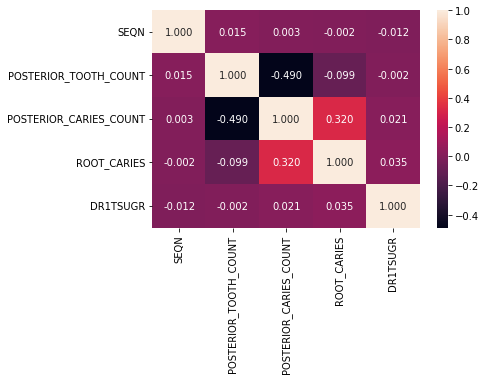

In [134]:
#caries to the sugars
import matplotlib.pyplot as plt
import seaborn as sns

print(df_dental.columns)
df_corr = df_data[['SEQN', 'POSTERIOR_TOOTH_COUNT', 'POSTERIOR_CARIES_COUNT',
       'ROOT_CARIES','DR1TSUGR']].corr()
ax = sns.heatmap(df_corr, annot=True, fmt=".3f")


Index(['SEQN', 'ANTERIOR_TOOTH_COUNT', 'POSTERIOR_TOOTH_COUNT',
       'ANTERIOR_CARIES_COUNT', 'POSTERIOR_CARIES_COUNT',
       'ANTERIOR_DENTAL_SEALANT_COUNT', 'POSTERIOR_DENTAL_SEALANT_COUNT',
       'ROOT_CARIES', 'OTHER_NON_CARIOUS_ROOT_LESION'],
      dtype='object')


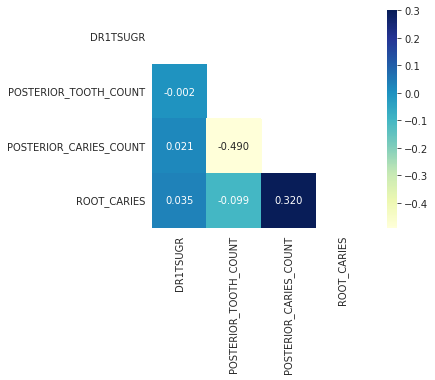

In [141]:
#caries to the sugars
import matplotlib.pyplot as plt
import seaborn as sns

print(df_dental.columns)
corr= df_data[['DR1TSUGR', 'POSTERIOR_TOOTH_COUNT', 'POSTERIOR_CARIES_COUNT',
       'ROOT_CARIES']].corr()


# corr = np.corrcoef(np.random.randn(10, 200))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr,mask=mask,annot=True, fmt=".03f",vmax=.3, square=True,  cmap="YlGnBu")
    plt.show()

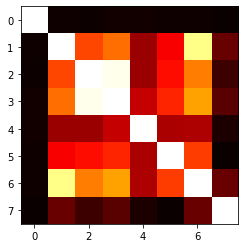

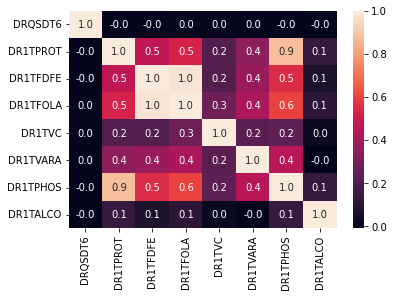

In [ ]:
df_corr = df_main.corr()
plt.imshow(df_corr, cmap='hot', interpolation='nearest')
plt.show()
# df_corr.style.highlight_max(color='yellow').highlight_min(color='blue')
ax = sns.heatmap(df_corr, annot=True, fmt=".1f")
# ax.set(xlabel=df_continuous_limited_variables_labels, ylabel=df_continuous_limited_variables_labels)




In [7]:
print(df_nutritions)

           SEQN  DSQTIODI      WTDRD1PP      WTDR2DPP DR1DRSTZ  DR1EXMER  \
0      109263.0      21.0  7.619484e+03  1.780807e+04      1.0      14.0   
1      109264.0       0.0  8.235896e+03  7.253762e+03      1.0      81.0   
2      109265.0       0.0  3.353508e+04  3.561201e+04      1.0      88.0   
3      109266.0       0.0  6.831068e+03  5.988204e+03      1.0      81.0   
4      109269.0       0.0  7.875707e+03  1.823193e+04      1.0      88.0   
...         ...       ...           ...           ...      ...       ...   
13767  124818.0     250.0  1.546208e+04  1.243740e+04      1.0      49.0   
13768  124819.0       0.0  4.091615e+03  4.100758e+03      1.0      14.0   
13769  124820.0       0.0  3.435783e+04  3.505186e+04      1.0      86.0   
13770  124821.0      40.0  3.043724e+03  5.397605e-79      1.0      81.0   
13771  124822.0      50.0  5.397605e-79  2.626910e+04      2.0      14.0   

      DRABF DRDINT       DR1DBIH DR1DAY  ... DRD370QQ DRD370R DRD370RQ  \
0       2.0  

In [79]:
[a1,b1,c1,a2,b2,c2,c3,a3,a4,b3,a5,a6,a7,b4,b5,b6,b7,c4,c5,c6,c7,d1,d2,d3,d4,d5,d6,d7] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for index,d in df_nutritions.iterrows():
  if(d["DR1DAY"]==1):
    a1= a1+d["DR1TCAFF"]
    b1= b1+d["DR1TPROT"]
    c1= c1+d["DR1TALCO"]
    d1= d1+d["DR1TALCO"]
  elif(d["DR1DAY"]==2):
    a2= a2+d["DR1TCAFF"]
    b2= b2+d["DR1TPROT"]
    c2= c2+d["DR1TALCO"]
    d2= d2+d["DR1TALCO"]
  elif(d["DR1DAY"]==3):
    a3= a3+d["DR1TCAFF"]
    b3= b3+d["DR1TPROT"]
    c3= c3+d["DR1TALCO"]
    d3= c3+d["DR1TALCO"]
  elif(d["DR1DAY"]==4):
    a4= a4+d["DR1TCAFF"]
    b4= b4+d["DR1TPROT"]
    c4= c4+d["DR1TALCO"]
    d4= c4+d["DR1TALCO"]
  elif(d["DR1DAY"]==5):
    a5= a5+d["DR1TCAFF"]
    b5= b5+d["DR1TPROT"]
    c5= c5+d["DR1TALCO"]
    d5= d5+d["DR1TALCO"]
  elif(d["DR1DAY"]==6):
    a6= a6+d["DR1TCAFF"]
    b6= b6+d["DR1TPROT"]
    c6= c6+d["DR1TALCO"]
    d6= d6+d["DR1TALCO"]

  elif(d["DR1DAY"]==7):
    a7= a7+d["DR1TCAFF"]
    b7= b7+d["DR1TPROT"]
    c7= c7+d["DR1TALCO"]
    d7= d7+d["DR1TALCO"]
Y_carb = [a1/len(df_nutritions),a2/len(df_nutritions),a3/len(df_nutritions),a4/len(df_nutritions),a4/len(df_nutritions),a6/len(df_nutritions),a7/len(df_nutritions)]
Y_protein = [b1/len(df_nutritions),b2/len(df_nutritions),b3/len(df_nutritions),b4/len(df_nutritions),b5/len(df_nutritions),b6/len(df_nutritions),b7/len(df_nutritions)]
Y_alcohol = [c1/len(df_nutritions),c2/len(df_nutritions),c3/len(df_nutritions),c4/len(df_nutritions),c5/len(df_nutritions),c6/len(df_nutritions),c7/len(df_nutritions)]
Y_caffeine = [d1/len(df_nutritions),d2/len(df_nutritions),d3/len(df_nutritions),d4/len(df_nutritions),d5/len(df_nutritions),d6/len(df_nutritions),d7/len(df_nutritions)]

[14.754630284310155, 6.737270461715189, 9.056247154677825, 7.465557820685614, 7.465557820685614, 32.622757234497, 18.068247221668305]
[11.257501640677713, 5.135291064029845, 5.301374709029621, 5.390948338170747, 6.226412754261769, 24.91607576784682, 15.400416257484114]
[1.0721866774444557, 0.3266340700418921, 0.47784665068144533, 0.3719470115379686, 0.5914103785762993, 1.98911633565805, 1.5210285920959354]


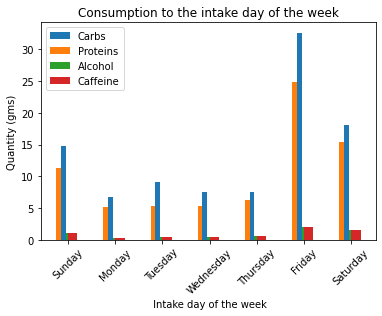

In [83]:
print(Y_carb)
print(Y_protein)
print(Y_alcohol)
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
  
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.1, Y_carb, 0.1, label = 'Carbs')
plt.bar(X_axis - 0.2, Y_protein, 0.1, label = 'Proteins')
plt.bar(X_axis , Y_alcohol, 0.1, label = 'Alcohol')
plt.bar(X_axis+0.1 , Y_caffeine, 0.2, label = 'Caffeine')
  
plt.xticks(X_axis, X,rotation=45)
plt.xlabel(" Intake day of the week")
plt.ylabel("Quantity (gms)")
plt.title("Consumption to the intake day of the week")
plt.legend()
plt.show()

[14.754630284310155, 6.737270461715189, 9.056247154677825, 7.465557820685614, 7.465557820685614, 32.622757234497, 18.068247221668305]
[16.57362560945168, 7.396015351556855, 7.6674286794817235, 7.91413669748269, 8.610609361458309, 36.33070135440773, 21.870306855425163]
[16.57362560945168, 7.396015351556855, 7.6674286794817235, 7.91413669748269, 8.610609361458309, 36.33070135440773, 21.870306855425163]


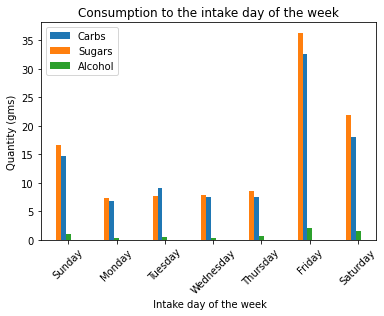

In [62]:
[a1,b1,c1,a2,b2,c2,c3,a3,a4,b3,a5,a6,a7,b4,b5,b6,b7,c4,c5,c6,c7] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for index,d in df_nutritions.iterrows():
  if(d["DR1DAY"]==1):
    a1= a1+d["DR1TCAFF"]
    b1= b1+d["DR1TSUGR"]
    c1= c1+d["DR1TALCO"]
  elif(d["DR1DAY"]==2):
    a2= a2+d["DR1TCAFF"]
    b2= b2+d["DR1TSUGR"]
    c2= c2+d["DR1TALCO"]
  elif(d["DR1DAY"]==3):
    a3= a3+d["DR1TCAFF"]
    b3= b3+d["DR1TSUGR"]
    c3= c3+d["DR1TALCO"]
  elif(d["DR1DAY"]==4):
    a4= a4+d["DR1TCAFF"]
    b4= b4+d["DR1TSUGR"]
    c4= c4+d["DR1TALCO"]
  elif(d["DR1DAY"]==5):
    a5= a5+d["DR1TCAFF"]
    b5= b5+d["DR1TSUGR"]
    c5= c5+d["DR1TALCO"]
  elif(d["DR1DAY"]==6):
    a6= a6+d["DR1TCAFF"]
    b6= b6+d["DR1TSUGR"]
    c6= c6+d["DR1TALCO"]

  elif(d["DR1DAY"]==7):
    a7= a7+d["DR1TCAFF"]
    b7= b7+d["DR1TSUGR"]
    c7= c7+d["DR1TALCO"]
Y_carb = [a1/len(df_nutritions),a2/len(df_nutritions),a3/len(df_nutritions),a4/len(df_nutritions),a4/len(df_nutritions),a6/len(df_nutritions),a7/len(df_nutritions)]
Y_sugar = [b1/len(df_nutritions),b2/len(df_nutritions),b3/len(df_nutritions),b4/len(df_nutritions),b5/len(df_nutritions),b6/len(df_nutritions),b7/len(df_nutritions)]
Y_alcohol = [c1/len(df_nutritions),c2/len(df_nutritions),c3/len(df_nutritions),c4/len(df_nutritions),c5/len(df_nutritions),c6/len(df_nutritions),c7/len(df_nutritions)]
print(Y_carb)
print(Y_sugar)
print(Y_sugar)
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
  
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.1, Y_carb, 0.1, label = 'Carbs')
plt.bar(X_axis - 0.2, Y_sugar, 0.1, label = 'Sugars')
plt.bar(X_axis , Y_alcohol, 0.1, label = 'Alcohol')
  
plt.xticks(X_axis, X,rotation=45)
plt.xlabel(" Intake day of the week")
plt.ylabel("Quantity (gms)")
plt.title("Consumption to the intake day of the week")
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


0     6.0
1     6.0
2     4.0
3     7.0
4     1.0
     ... 
95    6.0
96    7.0
97    5.0
98    7.0
99    1.0
Name: DR1DAY, Length: 100, dtype: category
Categories (7, float64): [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]


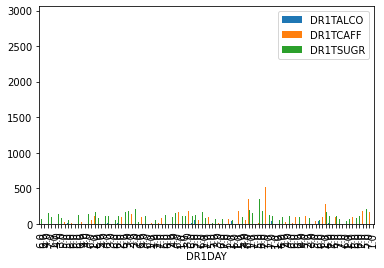

In [85]:
import matplotlib.pyplot as plt
df_nutritions = df_nutritions[:100]
df_nutritions1 = df_nutritions.set_index("DR1DAY")
print(df_nutritions["DR1DAY"]) #DR1DAY - Intake day of the week
inputs = ['DR1TALCO','DR1TCAFF','DR1TSUGR']
x= df_nutritions1[inputs]
y = df_nutritions["DR1DAY"]
plotdata = pd.DataFrame(x)
# Plot a bar chart
plotdata.plot(kind="bar")

In [86]:
# spliiting teh columns names to categorical variables and continuous variables
binary_df_columns = []
teritionary_df_columns = []
constant_df_columns = []
continuous_variables=[]
all_categorical_columns =[]

for h in df_nutritions.columns:
  d = set(df_nutritions[h])
  if(len(d)==2):
    all_categorical_columns.append(h)
    binary_df_columns.append(h)
  elif(len(d)<=5 and len(d)>2):
    all_categorical_columns.append(h)
    teritionary_df_columns.append(h)
  elif(len(d)==1):
    constant_df_columns.append(h)
  else:
    continuous_variables.append(h)

In [87]:
#getting teh highly correlated values
df_nutritions
df_corr = df_nutritions[continuous_variables].corr()
np.fill_diagonal(df_corr.values, 0)
df_corr.style.highlight_max(color='yellow').highlight_min(color='blue')
sorted_mat = df_corr.unstack().sort_values()
sorted_mat.iloc[3::30]
# print("DZ")
# print(sorted_mat[30:-1])
# print(len(sorted_mat))

DR1TS080  DR1EXMER   -0.204270
DR1TVD    DR1_320Z   -0.149418
DRD370MQ  DR1TRET    -0.131565
DRD370BQ  DR1BWATZ   -0.122806
DR1TB12A  DR1TCHOL   -0.117068
                        ...   
DR1TM161  DR1TTFAT    0.814980
DR1TPROT  DR1TZINC    0.836286
DR1TFA    DR1TFOLA    0.855528
DR1TTFAT  DR1TS180    0.889466
DR1TS180  DR1TSFAT    0.945425
Length: 203, dtype: float64

In [89]:
#Continuous variables analysis
df_continuous_variables_all = df_nutritions[continuous_variables]
df_continuous_variables_labels = ["Folate", "Sodium", "Total monounsaturated fatty acids", "Vitamin A, RAE", "Phosphorus", "Alcohol", "Energy (kcal)"]
df_continuous_variables = ["DR1TFDFE", "DR1TSODI", "DR1TMFAT", "DR1TVARA", "DR1TPHOS" ,"DR1TALCO","DR1TKCAL"]
df_continuous_variables_labels_gms = ["Carbohydrate", "Total sugars", "Dietary fiber", "Moisture","Magnesium", "Caffeine", "Alcohol"]
df_continuous_variables_gms = ["DR1TCARB", "DR1TSUGR", "DR1TFIBE", "DR1TMOIS", "DR1TMAGN","DR1TCAFF","DR1TALCO","DR1TSODI"]
df_continuous_variables = df_nutritions[df_continuous_variables]
df_continuous_variables_gm1 = df_nutritions[df_continuous_variables_gms[:2]]
df_continuous_variables_gm1 =df_continuous_variables_gm1 
df_continuous_variables_gm2 = df_nutritions[df_continuous_variables_gms[2:]]
df_continuous_variables_gm2 =df_continuous_variables_gm2*0.001
df_continuous_variables_gm = [df_continuous_variables_gm1,df_continuous_variables_gm2]
result = pd.concat(df_continuous_variables_gm, axis=1)

sd= ["DR1TKCAL","DR1TPROT","DR1TCARB"]
df_nutritions[sd].corr()



,DR1TKCAL,DR1TPROT,DR1TCARB
DR1TKCAL,1.000000,0.876614,0.842072
DR1TPROT,0.876614,1.000000,0.569256
DR1TCARB,0.842072,0.569256,1.000000


In [ ]:
print(result)
result.rename(columns = {'DR1TFIBE' : 'Dietary fiber', 'DR1TCARB' : 'Carbohydrate',"DR1TMAGN":" Magnesium", "DR1TCAFF":"Caffeine","DR1TALCO":"Alcohol","DR1TSUGR":"Added Sugars"}, inplace = True)
print(result.columns)
a= ['Added Sugars', 'Dietary fiber','Carbohydrate', 'Caffeine', 'Alcohol']
from google.colab import files
result[a].to_csv('filename.csv') 
files.download('filename.csv')

       Carbohydrate  Added Sugars  Dietary fiber  DR1TMOIS   Magnesium  \
0        187.650000     73.420000       0.009400  1.068500    0.175000   
1        121.680000     27.860000       0.008200  2.097290    0.167000   
2        246.530000    157.080000       0.007600  1.529720    0.200000   
3        217.690000     94.200000       0.020700  3.758320    0.300000   
4        159.990000     84.830000       0.005100  0.788860    0.085000   
...             ...           ...            ...       ...         ...   
13767    512.140000    278.840000       0.015000  2.800710    0.186000   
13768    197.260000    108.360000       0.008300  1.229350    0.201000   
13769    157.810000     65.770000       0.012300  0.702790    0.161000   
13770    110.590000     50.570000       0.006700  2.779430    0.236000   
13771    242.503484    106.362824       0.015196  2.439592    0.267535   

           Caffeine       Alcohol  DR1TSODI  
0      2.000000e-03  5.397605e-82   2.45600  
1      1.000000e-03

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plot
sns.set_style("whitegrid")
  
sns.boxplot( data = result[:2],'cyan')
ax.set_yticklabels(df_continuous_variables_labels_gms[:2])
 
# Adding title
plt.title("Nutritional attributes box plot")

# b_plot = result.boxplot(column = df_continuous_variables_gms) 
# b_plot.plot()
plot.show()

SyntaxError: ignored

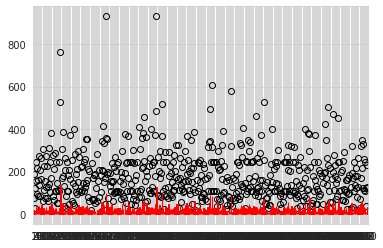

In [ ]:
import matplotlib.pyplot as plt

def box_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp


fig, ax = plt.subplots()
bp1 = box_plot(result[:300], 'red', 'tan')
# bp2 = box_plot(example_data2, 'blue', 'cyan')
# ax.legend([bp1["boxes"][0]], ['Data 2'])
# ax.set_ylim(0, 10)
plt.show()


In [ ]:
print(df_continuous_variables_labels_gms[:3])

['Carbohydrate', 'Total sugars', 'Dietary fiber']


In [ ]:
print(result)

     Carbohydrate  Total sugars   Dietary fiber  Moisture   Magnesium  \
0      187.650000     73.420000        0.009400  1.068500    0.175000   
1      121.680000     27.860000        0.008200  2.097290    0.167000   
2      246.530000    157.080000        0.007600  1.529720    0.200000   
3      217.690000     94.200000        0.020700  3.758320    0.300000   
4      159.990000     84.830000        0.005100  0.788860    0.085000   
..            ...           ...             ...       ...         ...   
295    329.290000    123.660000        0.024700  7.213810    0.352000   
296    258.790000    110.670000        0.017600  5.951040    0.404000   
297    242.503484    106.362824        0.015196  2.439592    0.267535   
298    120.200000     34.970000        0.012900  2.653300    0.169000   
299    230.600000    127.270000        0.015600  2.942240    0.333000   

         Caffeine       Alcohol   Sodium  
0    2.000000e-03  5.397605e-82  2.45600  
1    1.000000e-03  5.397605e-82  1.70

Index(['Carbohydrate', 'Total sugars', ' Dietary fiber', 'Moisture',
       ' Magnesium', 'Caffeine', 'Alcohol', 'Sodium'],
      dtype='object')


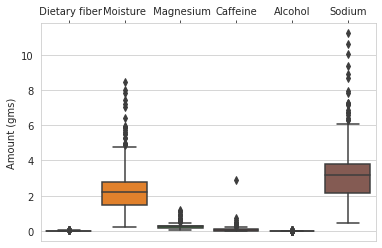

In [ ]:
#plotting second outlierrs plot
import matplotlib.pyplot as plot
sns.set_style("whitegrid")
df_continuous_variables_labels_gms = ["Carbohydrate", "Total sugars", "Dietary fiber", "Moisture","Magnesium", "Caffeine", "Alcohol","Sodium"]
df_continuous_variables_gms = ["DR1TCARB", "DR1TSUGR", "DR1TFIBE", "DR1TMOIS", "DR1TMAGN","DR1TCAFF","DR1TALCO","DR1TSODI"]
# a = ["Carbohydrate", "DR1TSUGR"]

result.rename(columns = {'DR1TFIBE' : 'Dietary fiber', 'DR1TMOIS' : 'Moisture',"DR1TMAGN":" Magnesium", "DR1TCAFF":"Caffeine","DR1TALCO":"Alcohol","DR1TSODI":"Sodium"}, inplace = True)
# result.columns = result.columns.str.replace(df_continuous_variables_labels_gms)
result = result[:300]
print(result.columns)
a= [' Dietary fiber', 'Moisture',' Magnesium', 'Caffeine', 'Alcohol', 'Sodium']
ax = sns.boxplot( data = result[a])
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
# ax.set_yticklabels(df_continuous_variables_labels_gms[:3])
# ax.set(xlabel='df_continuous_variables_labels_gms', ylabel='Amount (gms)')
# plt.xlabel(df_continuous_variables_labels_gms)
plt.ylabel("Amount (gms)")
# # Adding title
# plt.title("Nutritional attributes box plot")

# b_plot = result.boxplot(column = df_continuous_variables_gms) 
# b_plot.plot()
plot.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Index(['Carbohydrate', 'Total sugars', ' Dietary fiber', 'Moisture',
       ' Magnesium', 'Caffeine', 'Alcohol', 'Sodium'],
      dtype='object')


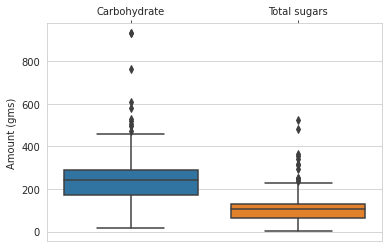

In [ ]:
import matplotlib.pyplot as plot
sns.set_style("whitegrid")
df_continuous_variables_labels_gms = ["Carbohydrate", "Total sugars", "Dietary fiber", "Moisture","Magnesium", "Caffeine", "Alcohol","Sodium"]
df_continuous_variables_gms = ["DR1TCARB", "DR1TSUGR", "DR1TFIBE", "DR1TMOIS", "DR1TMAGN","DR1TCAFF","DR1TALCO","DR1TSODI"]
# a = ["Carbohydrate", "DR1TSUGR"]

result.rename(columns = {'cc' : 'Carbohydrate', 'DR1TSUGR' : 'Total sugars',"DR1TFIBE":" Dietary fiber"}, inplace = True)
# result.columns = result.columns.str.replace(df_continuous_variables_labels_gms)
result = result[:300]
print(result.columns)
a= ['Carbohydrate', 'Total sugars']
ax = sns.boxplot( data = result[a])
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
# ax.set_yticklabels(df_continuous_variables_labels_gms[:3])
# ax.set(xlabel='df_continuous_variables_labels_gms', ylabel='Amount (gms)')
# plt.xlabel(df_continuous_variables_labels_gms)
plt.ylabel("Amount (gms)")
# # Adding title
# plt.title("Nutritional attributes box plot")

# b_plot = result.boxplot(column = df_continuous_variables_gms) 
# b_plot.plot()
plot.show()

In [ ]:
print

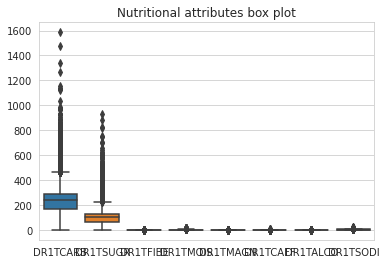

In [ ]:
import matplotlib.pyplot as plot
sns.set_style("whitegrid")
  
sns.boxplot( data = result[:-4])
ax.set_yticklabels(df_continuous_variables_labels_gms[2:])
 
# Adding title
plt.title("Nutritional attributes box plot")

# b_plot = result.boxplot(column = df_continuous_variables_gms) 
# b_plot.plot()
plot.show()

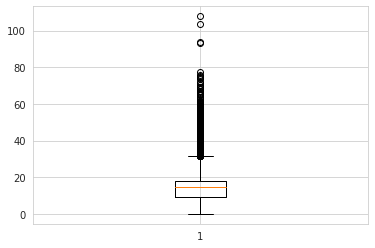

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

c= ["DR1TMAGN","DR1TCAFF" ,"DR1TALCO"]
# Creating plot
plt.boxplot(result["DR1TFIBE"])
 
# show plot
plt.show()

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

c= ["DR1TMAGN","DR1TCAFF" ,"DR1TALCO"]
# Creating plot
plt.boxplot(result[c[0:2]])
 
# show plot
plt.show()

In [ ]:

# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(result[:7])
 
# show plot
plt.show()

In [ ]:
import numpy as np

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(result[:7], patch_artist = True,
                notch ='True', vert = 0)
 
colors = ['#0000FF', '#00FF00',
          '#FFFF00', '#FF00FF']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_yticklabels(df_continuous_variables_labels_gms)
 
# Adding title
plt.title("Nutritional attributes box plot")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()

In [ ]:
sns.set_style("whitegrid")
  
sns.boxplot(x = 'day', y = 'total_bill', data = result)

NameError: ignored

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')
ax= sns.boxplot(x=df_continuous_variables_labels_gms,y='Age',data=result)
ax = sns.stripplot(x="Survived", y="Age",data=result)


In [ ]:
df_continuous_variables

In [ ]:
df_corr = df_continuous_variables.corr()
np.fill_diagonal(df_corr.values, 0)
df_corr.style.highlight_max(color='yellow').highlight_min(color='blue')

In [ ]:
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
plt.imshow(df_corr, cmap='hot', interpolation='nearest')
# df_corr.style.highlight_max(color='yellow').highlight_min(color='blue')
ax = sns.heatmap(df_corr, annot=True, fmt=".1f")


In [ ]:
#getting csv file for grpahs plotting
from google.colab import files
df_continuous_variables.to_csv('filename.csv') 
files.download('filename.csv')

In [ ]:
#salmon vs mackeral eaten last 30 days
import matplotlib.pyplot as plt
  
# x axis values
x = df_nutritions["DRD370MQ"]
# corresponding y axis values
y = df_nutritions["DRD370HQ"]

plt.plot(x, y)

plt.xlabel('# of times salmon eaten past 30 days')
# naming the y axis
plt.ylabel('# of times mackerel eaten past 30 days')
  
# giving a title to my graph
plt.title('My first graph!')
  
# function to show the plot
plt.show()
